In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import files

DEFAULT_PATH = '/mnt/data/final_dataset.csv'

def load_csv_interactive(default_path=DEFAULT_PATH):
    if os.path.exists(default_path):
        print(f"Found file at {default_path} — loading...")
        return pd.read_csv(default_path)
    else:
        print("Upload your dataset file:")
        uploaded = files.upload()
        fname = list(uploaded.keys())[0]
        return pd.read_csv(fname)

df = load_csv_interactive()

print("Dataset Loaded Successfully!")
print(df.shape)
df.head()


Upload your dataset file:


Saving final_dataset.csv to final_dataset.csv
Dataset Loaded Successfully!
(1461, 12)


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df['Datetime'] = pd.to_datetime(
    dict(year=df['Year'], month=df['Month'], day=df['Date']),
    errors='coerce'
)

df = df.sort_values("Datetime").reset_index(drop=True)
df.head()


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI,Datetime
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462,2021-01-01
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482,2021-01-02
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263,2021-01-03
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207,2021-01-04
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149,2021-01-05


In [ ]:
def categorize_aqi(aqi):
    if aqi <= 50:   return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    elif aqi <= 400: return "Very Poor"
    else:           return "Severe"

df["AQI_Category"] = df["AQI"].apply(categorize_aqi)
df[["AQI", "AQI_Category"]].head()


,AQI,AQI_Category
0,462,Severe
1,482,Severe
2,263,Poor
3,207,Poor
4,149,Moderate


In [ ]:


pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone", "AQI"]

for col in pollutants:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag3"] = df[col].shift(3)
    df[f"{col}_lag7"] = df[col].shift(7)

for col in pollutants:
    df[f"{col}_roll3"] = df[col].rolling(window=3).mean()
    df[f"{col}_roll5"] = df[col].rolling(window=5).mean()

df = df.dropna().reset_index(drop=True)

df.head()



,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,...,NO2_roll3,NO2_roll5,SO2_roll3,SO2_roll5,CO_roll3,CO_roll5,Ozone_roll3,Ozone_roll5,AQI_roll3,AQI_roll5
0,8,1,2021,0,5,140.05,184.29,102.61,10.34,0.79,...,114.730000,124.166,10.146667,10.112,0.900000,0.870,45.376667,46.840,262.666667,228.8
1,9,1,2021,0,6,144.01,192.43,108.43,10.41,0.85,...,103.303333,115.056,10.186667,10.110,0.790000,0.838,44.630000,45.448,287.333333,252.6
2,10,1,2021,1,7,131.57,180.38,93.31,9.92,0.69,...,101.450000,109.186,10.223333,10.154,0.776667,0.848,45.750000,46.064,286.000000,279.6
3,11,1,2021,0,1,135.92,208.99,105.07,10.49,0.75,...,102.270000,101.658,10.273333,10.194,0.763333,0.762,49.750000,48.182,297.000000,285.4
4,12,1,2021,0,2,172.48,220.74,111.52,10.21,0.91,...,103.300000,104.188,10.206667,10.274,0.783333,0.798,49.570000,46.800,298.000000,293.6


In [ ]:
exclude_cols = ["AQI_Category", "Datetime", "Year", "Month", "Date"]
feature_cols = [c for c in df.columns if c not in exclude_cols]

X = df[feature_cols]
y = df["AQI_Category"]

print("Feature Count:", len(feature_cols))


Feature Count: 44


In [ ]:
train_mask = df["Year"] <= 2023
test_mask  = df["Year"] == 2024

X_train = X[train_mask]
y_train = y[train_mask]

X_test  = X[test_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape


((1088, 44), (366, 44))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9918032786885246

Classification Report:
               precision    recall  f1-score   support

        Good       0.89      0.89      0.89         9
    Moderate       1.00      1.00      1.00       125
        Poor       0.99      1.00      1.00       105
Satisfactory       0.99      0.99      0.99        69
      Severe       1.00      1.00      1.00         8
   Very Poor       1.00      0.98      0.99        50

    accuracy                           0.99       366
   macro avg       0.98      0.98      0.98       366
weighted avg       0.99      0.99      0.99       366


Confusion Matrix:
 [[  8   0   0   1   0   0]
 [  0 125   0   0   0   0]
 [  0   0 105   0   0   0]
 [  1   0   0  68   0   0]
 [  0   0   0   0   8   0]
 [  0   0   1   0   0  49]]


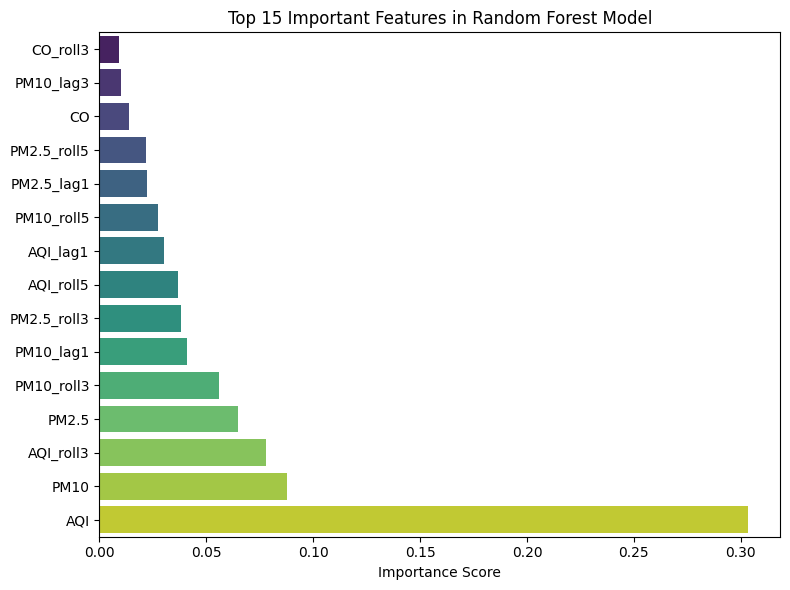

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances[indices],
    y=np.array(feature_cols)[indices],
    palette="viridis"
)
plt.title("Top 15 Important Features in Random Forest Model")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
last_row_df = pd.DataFrame([X.iloc[-1]], columns=X.columns)

tomorrow_pred = rf.predict(last_row_df)[0]
print("Predicted AQI Category for Next Day:", tomorrow_pred)



Predicted AQI Category for Next Day: Poor


In [ ]:
knn_accuracy = 0.8883
rf_accuracy  = accuracy_score(y_test, y_pred)

print("KNN Accuracy:", knn_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

if rf_accuracy > knn_accuracy:
    print("\nRandom Forest performs BETTER than KNN .")
else:
    print("\n KNN performs better, investigate tuning.")


KNN Accuracy: 0.8883
Random Forest Accuracy: 0.9918032786885246

Random Forest performs BETTER than KNN .
